## Parte 2. Análisis y reporte de desempeño del modelo sobre los datos.

In [1]:
# Cargar algunas librerías extras para el análisis y validación de los modelos implementados
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

c:\Users\fcsal\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\fcsal\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\fcsal\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Cargar el conjunto de datos
data = load_breast_cancer()
X = data.data
y = data.target

In [3]:
# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)


Debido a que utilizaremos GridSearchCV para el ajuste de algunos de nuestros hiperparámetros, aún no creamos nuestro validation set, este será creado con el objeto sklearn.model_selection.GridSearchCV() con el hiperparámetro cv y alimentando al objeto nuestro X_train y y_train, primeramente defineremos que el cross-validation (cv) sea igual a 2 para que se haga la evaluación de modelos unicamenente en un validation_set, después se evaluará también el modelo pero ahora usando cross-validation de varios "folds" para analizar los cambios de desempeño entre modelos.

### Entrenando el modelo y evaluando el modelo en el conjunto de prueba sin ajuste de hiper-parámetros o uso de conojuntos de validación

In [4]:
# Entrenar un modelo de árbol de decisión
clf1 = DecisionTreeClassifier(random_state=23)
clf1.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred1 = clf1.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred1)

print("Accuracy en el conjunto de prueba:", accuracy1)
print("\nReporte de clasificación en el conjunto de prueba:\n", classification_report(y_test, y_pred1))
print("\nMatriz de confusión en el conjunto de prueba:\n", confusion_matrix(y_test, y_pred1))


Accuracy en el conjunto de prueba: 0.9298245614035088

Reporte de clasificación en el conjunto de prueba:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89        39
           1       0.94      0.96      0.95        75

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114


Matriz de confusión en el conjunto de prueba:
 [[34  5]
 [ 3 72]]


El modelo de arbol de decisión para clasificación implementado en scikit-learn con sus hiperparámetros por default tiene un buen rendimiento en general cuando es entrenado y evaluado con el train y test set respectivamente del dataset de breast_cancer, se tiene un buen porcentaje de precisión y recall , el accuracy nos indica que el modelo pudo clasificar de forma correcta las instancias del test set en el 93% de los casos, por otra parte se tuvieron 3 falsos negativos, bajo el contexto de los datos, esto es muy malo debido a que no se diagnostica cancer a pacientes con cancer, sería mejor tener un modelo que a primera instancia clasifique más falsos positivos que falsos negativos, como se había dicho anteriormente, también es importante verificar que el alto rendimiento del modelo no se deba al desequilibrio de clases. Se buscará indagar en esto con la exploración de distintos hiper-parámetros y tener conjuntos de datos de entrenamiento, validación y prueba.

### Entrenando el modelo con train y validation set, luego evaluando el modelo con test set con ajuste de hiper-parámetros
Ahora para el ajuste de hiper-parámetros utilizaremos GridSearchCV, este método realiza una busqueda exhaustiva de todas las combinaciones posibles de hiperparámetros especificados, para nuestro caso variaremos 4 de los hiperparámetros existentes dentro de los objetos del tipo DecisionTreeClassifier(), los distintos modelos creados serán evaluados en una validation_set que se creará dentro del objeto GridSearchCV(), aquí el validation_set siempre será el mismo.

In [5]:
from sklearn.model_selection import GridSearchCV

# Definir una cuadrícula de hiperparámetros para buscar los mejores valores
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=23), param_grid=param_grid, cv=2, scoring='accuracy')

# Ajustar el modelo a los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
clf2 = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred2 = clf2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Accuracy en el conjunto de prueba con mejores hiperparámetros:", accuracy2)


Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy en el conjunto de prueba con mejores hiperparámetros: 0.9473684210526315


In [6]:
print("\nReporte de clasificación en el conjunto de prueba:\n", classification_report(y_test, y_pred2))
print("\nMatriz de confusión en el conjunto de prueba:\n", confusion_matrix(y_test, y_pred2))


Reporte de clasificación en el conjunto de prueba:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        39
           1       0.96      0.96      0.96        75

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


Matriz de confusión en el conjunto de prueba:
 [[36  3]
 [ 3 72]]


Aquí podemos observar una mejoría en el accuracy del modelo, pasando de 93% a 95%. Ahora se han reducido los falsos positivos a 1, cuando antes se tenían 3, aún y que esto presenta una mejoría en el accuracy del modelo, seguimos sin poder disminuir en número de falsos negativos que es lo que más nos interesa para este set de datos, veremos si utilizando validación cruzada podemos disminuir estos.

### Entrenando y evaluando el modelo con cross-validation score para ajuste de hiper-parámetros
Por otra parte, para mitigar el riesgo de un modelo con overfitting, utilizaremos validación cruzada, esta técnica divide el conjunto de datos en varios "folds", para así poder entrenar el modelo con distintas combinaciones del set generadas por estos pliegues y tener estimaciones más confiables en datos desconocidos, esto debería de pasar al menos en teoría.  

In [7]:
from sklearn.model_selection import GridSearchCV

# Definir una cuadrícula de hiperparámetros para buscar los mejores valores
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=23), param_grid=param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo a los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
clf3 = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred3 = clf3.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred3)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Accuracy en el conjunto de prueba con mejores hiperparámetros:", accuracy3)

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy en el conjunto de prueba con mejores hiperparámetros: 0.956140350877193


In [8]:
print("\nReporte de clasificación en el conjunto de prueba:\n", classification_report(y_test, y_pred3))
print("\nMatriz de confusión en el conjunto de prueba:\n", confusion_matrix(y_test, y_pred3))


Reporte de clasificación en el conjunto de prueba:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        39
           1       0.97      0.96      0.97        75

    accuracy                           0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Matriz de confusión en el conjunto de prueba:
 [[37  2]
 [ 3 72]]


Podemos observar que la optimización de hiper-parámetros con cross-validation en este caso no ha mejorado el desempeño final, incluso ha obtenido los mismos resultados que el modelo que utilizaba los hiperparámetros por default y sin conjunto de validación, con esto se puede concluir varias cosas, por ejemplo que los parámetros iniciales del modelo erán adecuados para nuestro conjunto de datos, también puede que la calidad y cantidad de los datos hagan que los hiperparámetros del modelo no puedan ser optimizados adecuadamente, oque el modelo en si tenga limitaciones para aprender patrones más complejos de los datos.

### Diagnóstico y explicación del grado de sesgo, varianza y nivel de ajuste del modelo

#### Para el primer modelo, sin ajuste de hiperparámetros

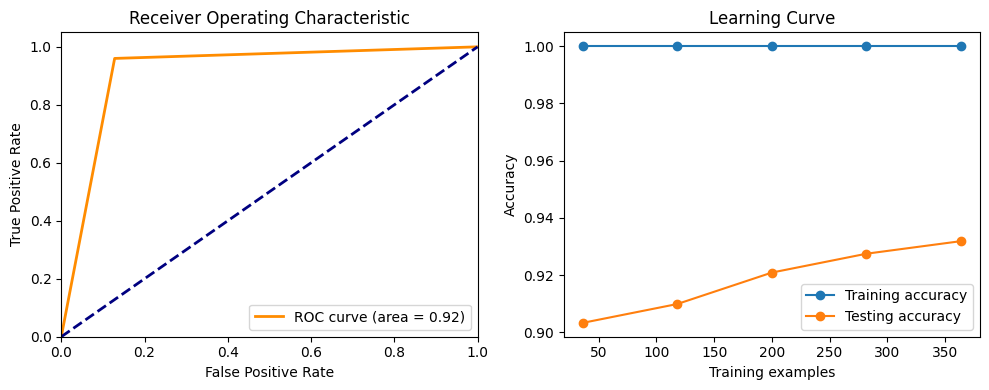

Precisión en el conjunto de entrenamiento: 1.0
Precisión en el conjunto de prueba: 0.9298245614035088
Área bajo la curva ROC: 0.9158974358974359
Sesgo (bias) alto
Varianza baja
Sobreajuste (overfitting)


In [9]:
# Evaluar el modelo en el conjunto de entrenamiento y prueba
y_train_pred = clf1.predict(X_train)
y_test_pred = clf1.predict(X_test)

# Calcular la precisión en el conjunto de entrenamiento y prueba
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcular las curvas ROC para evaluar la varianza
y_score = clf1.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
# Calcular las curvas ROC para evaluar la varianza
y_score = clf1.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Calcular la curva de aprendizaje para evaluar el sesgo
train_sizes, train_scores, test_scores = learning_curve(clf1, X_train, y_train, cv=5, scoring='accuracy')

# Plotea la curva ROC
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Plotea la curva de aprendizaje
plt.subplot(1, 2, 2)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Testing accuracy')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

print(f'Precisión en el conjunto de entrenamiento: {train_accuracy}')
print(f'Precisión en el conjunto de prueba: {test_accuracy}')
print(f'Área bajo la curva ROC: {roc_auc}')

# Analiza el sesgo, la varianza y el nivel de ajuste
if train_accuracy > test_accuracy:
    print('Sesgo (bias) alto')
else:
    print('Sesgo (bias) bajo')

if roc_auc < 0.5:
    print('Varianza alta')
else:
    print('Varianza baja')

if train_accuracy == test_accuracy:
    print('Ajuste perfecto')
elif train_accuracy > test_accuracy:
    print('Sobreajuste (overfitting)')
else:
    print('Subajuste (underfitting)')

#### Segundo modelo con ajuste de hiperparámetros sin validación cruzada

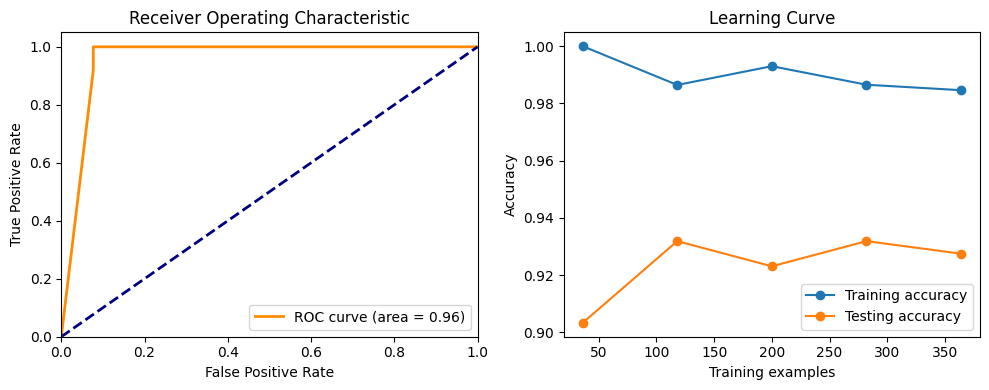

Precisión en el conjunto de entrenamiento: 0.9846153846153847
Precisión en el conjunto de prueba: 0.9473684210526315
Área bajo la curva ROC: 0.9584615384615385
Sesgo (bias) alto
Varianza baja
Sobreajuste (overfitting)


In [10]:
# Evaluar el modelo en el conjunto de entrenamiento y prueba
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)

# Calcular la precisión en el conjunto de entrenamiento y prueba
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcular las curvas ROC para evaluar la varianza
y_score = clf1.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
# Calcular las curvas ROC para evaluar la varianza
y_score = clf2.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Calcular la curva de aprendizaje para evaluar el sesgo
train_sizes, train_scores, test_scores = learning_curve(clf2, X_train, y_train, cv=5, scoring='accuracy')

# Plotea la curva ROC
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Plotea la curva de aprendizaje
plt.subplot(1, 2, 2)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Testing accuracy')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

print(f'Precisión en el conjunto de entrenamiento: {train_accuracy}')
print(f'Precisión en el conjunto de prueba: {test_accuracy}')
print(f'Área bajo la curva ROC: {roc_auc}')

# Analiza el sesgo, la varianza y el nivel de ajuste
if train_accuracy > test_accuracy:
    print('Sesgo (bias) alto')
else:
    print('Sesgo (bias) bajo')

if roc_auc < 0.5:
    print('Varianza alta')
else:
    print('Varianza baja')

if train_accuracy == test_accuracy:
    print('Ajuste perfecto')
elif train_accuracy > test_accuracy:
    print('Sobreajuste (overfitting)')
else:
    print('Subajuste (underfitting)')

#### Para el tercer modelo con cross-validation y ajuste de hiperparámetros

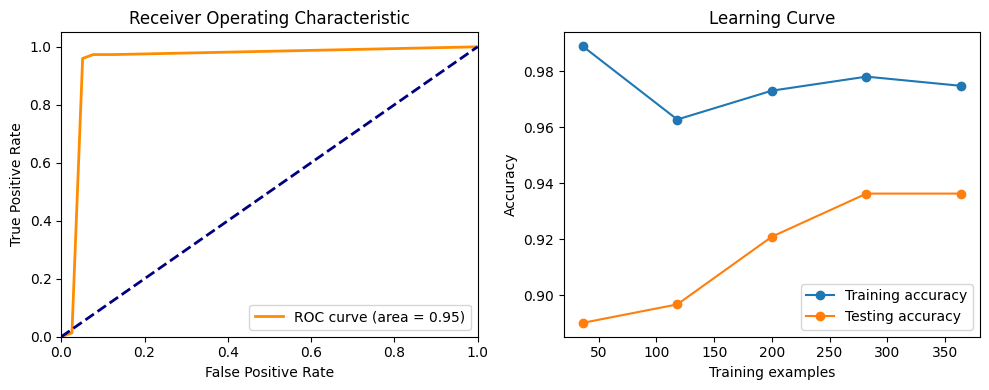

Precisión en el conjunto de entrenamiento: 0.9736263736263736
Precisión en el conjunto de prueba: 0.956140350877193
Área bajo la curva ROC: 0.9475213675213675
Sesgo (bias) alto
Varianza baja
Sobreajuste (overfitting)


In [11]:
# Evaluar el modelo en el conjunto de entrenamiento y prueba
y_train_pred = clf3.predict(X_train)
y_test_pred = clf3.predict(X_test)

# Calcular la precisión en el conjunto de entrenamiento y prueba
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcular las curvas ROC para evaluar la varianza
y_score = clf3.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
# Calcular las curvas ROC para evaluar la varianza
y_score = clf3.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Calcular la curva de aprendizaje para evaluar el sesgo
train_sizes, train_scores, test_scores = learning_curve(clf3, X_train, y_train, cv=5, scoring='accuracy')

# Plotea la curva ROC
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Plotea la curva de aprendizaje
plt.subplot(1, 2, 2)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Testing accuracy')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

print(f'Precisión en el conjunto de entrenamiento: {train_accuracy}')
print(f'Precisión en el conjunto de prueba: {test_accuracy}')
print(f'Área bajo la curva ROC: {roc_auc}')

# Analiza el sesgo, la varianza y el nivel de ajuste
if train_accuracy > test_accuracy:
    print('Sesgo (bias) alto')
else:
    print('Sesgo (bias) bajo')

if roc_auc < 0.5:
    print('Varianza alta')
else:
    print('Varianza baja')

if train_accuracy == test_accuracy:
    print('Ajuste perfecto')
elif train_accuracy > test_accuracy:
    print('Sobreajuste (overfitting)')
else:
    print('Subajuste (underfitting)')